In [ ]:
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import Sequential, layers, datasets
from sklearn.model_selection import train_test_split

In [ ]:
stats = []
models = []

def densenet():
  return Sequential([
      layers.Flatten(input_shape=(28, 28)),
      layers.Dense(16, activation='relu'),
      layers.Dense(10),
  ], name='densenet')
models.append(densenet)

def convnet():
  return Sequential([
      layers.Conv2D(64, (3, 3), activation='relu', input_shape=(28, 28, 1)),
      layers.MaxPooling2D((2, 2)),
      layers.BatchNormalization(),
      layers.Conv2D(32, (3, 3), activation='relu'),
      layers.MaxPooling2D((2, 2)),
      layers.BatchNormalization(),
      layers.Conv2D(16, (3, 3), activation='relu'),
      layers.MaxPooling2D((2, 2)),
      layers.BatchNormalization(),
      layers.Flatten(),
      layers.Dense(128, activation='relu'),
      layers.Dropout(.2),
      layers.Dense(10),
  ], name='convnet')
models.append(convnet)

In [ ]:
(_, _), (X, y) = datasets.mnist.load_data()
X = X / 255.
rX_train, rX_test, ry_train, ry_test = train_test_split(X, y, test_size=.3)
len(rX_train), len(rX_test), rX_train.shape

11490434/11490434 [==============================] - 0s 0us/step


(7000, 3000, (7000, 28, 28))

In [ ]:
for test_size in [.1, .3, .5]:
  X_train, X_test, y_train, y_test = train_test_split(rX_train, ry_train, test_size=test_size)
  for model_fn in models:
    for lr in [.1, .3]:
      for epoch_rate in [50, 100]:
        model = model_fn()
        loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
        optimizer = tf.keras.optimizers.SGD(learning_rate=lr)
        model.compile(loss=loss_fn, optimizer=optimizer, metrics=['accuracy'])
        h = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=epoch_rate)
        stats.append({'name': model.name, 'lr': lr, 'epoch_rate': h.epoch, 'h': h, 'test_size': test_size})

In [ ]:
# plot best and worst performing models
def plot(stats):
  plt.figure(figsize=(15, 80))
  s = 1
  for stat in stats:
    plt.subplot(18, 2, s)
    acc = stat['h'].history['val_accuracy'][-1] * 100
    name = f"{stat['name']} lr:{stat['lr']} epochs:{stat['epoch_rate'].__len__()} acc:{acc:.1f}% test_size:{stat['test_size'] * 100}%"
    plt.title(name, pad=2)
    plt.plot(stat['epoch_rate'], stat['h'].history['loss'])
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    s += 1

In [ ]:
def query_stats(model=None, lr=None, epochs=None, test_size=None) -> list[list, list]:
  """
  return: [best, worst] for given query
  """
  global stats
  buf = stats.copy()
  if model:
    buf = list(filter(lambda stat: stat['name'] == model, buf))
  if lr:
    buf = list(filter(lambda stat: stat['lr'] == lr, buf))
  if epochs:
    buf = list(filter(lambda stat: len(stat['epoch_rate']) == epochs, buf))
  if test_size:
    buf = list(filter(lambda stat: stat['test_size'] == test_size, buf))
  buf.sort(key=lambda stat: stat['h'].history['val_accuracy'][-1] * 100, reverse=True)
  return [buf[0], buf[-1]]

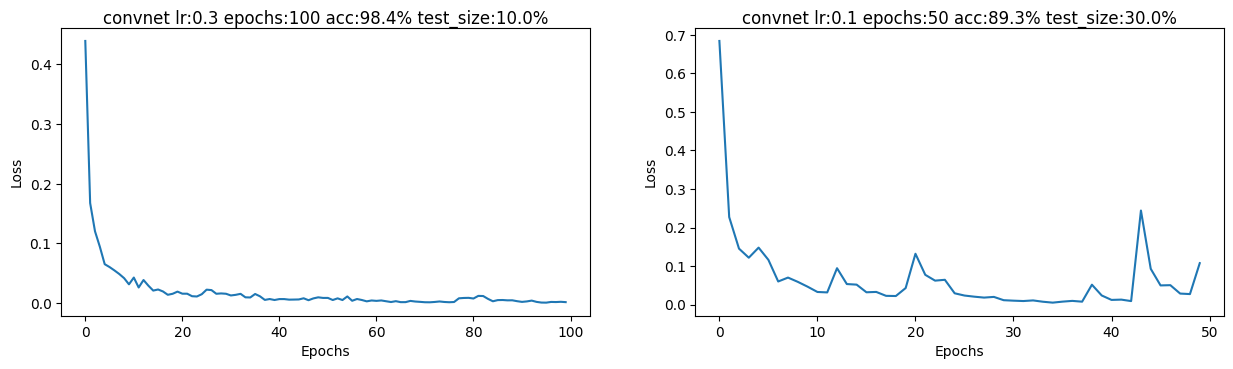

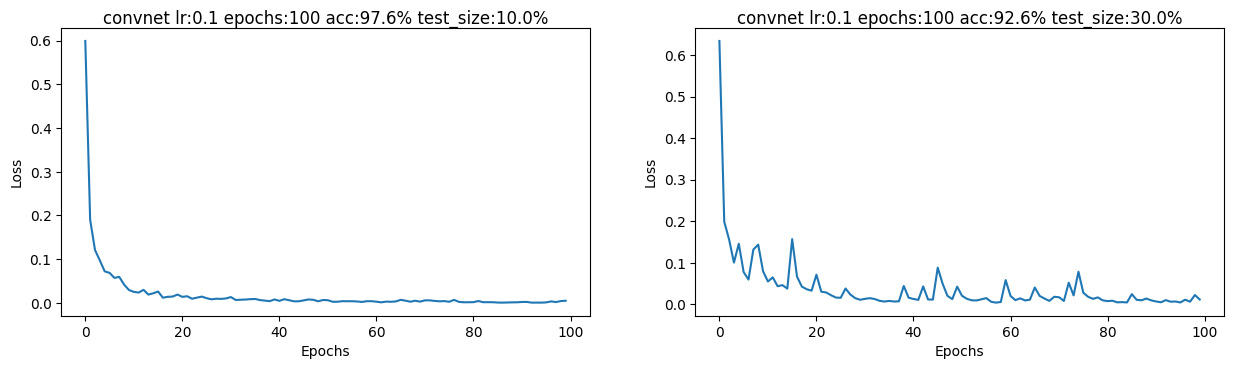

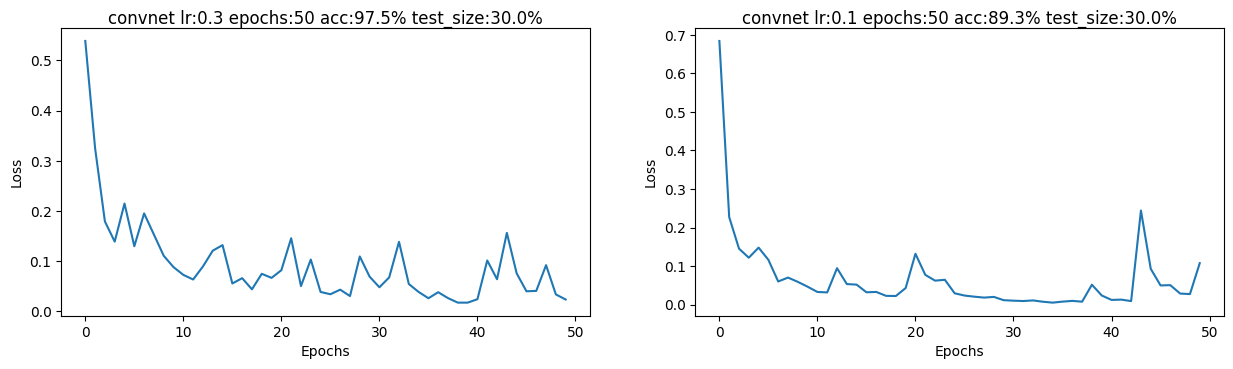

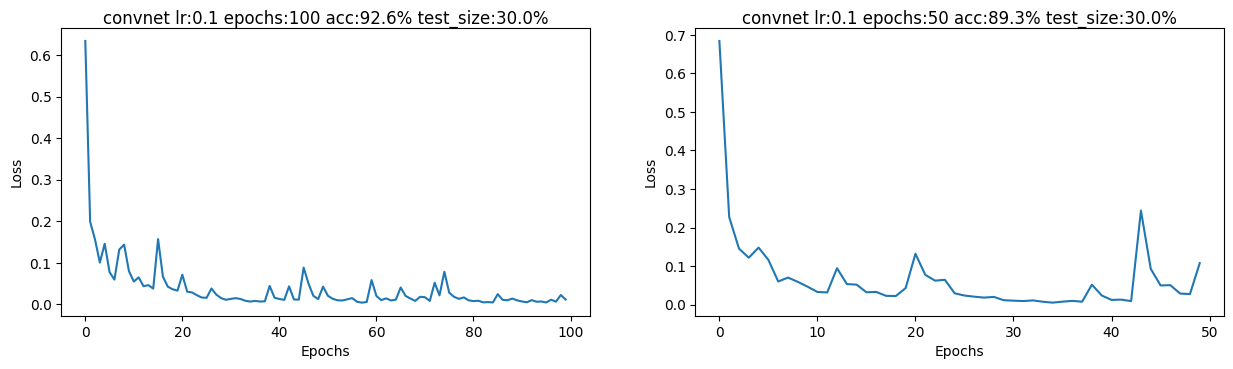

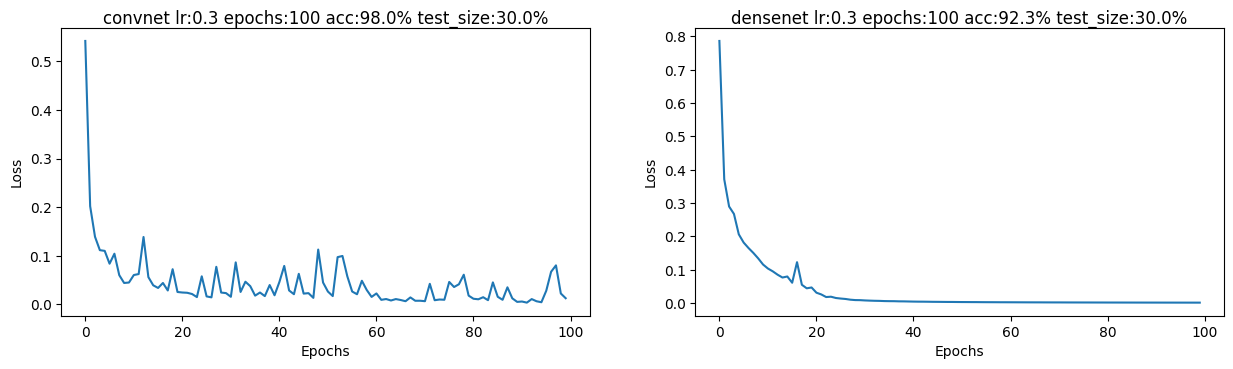

In [ ]:
# Best and Worst model
plot(query_stats())
# Effect of test size
plot(query_stats(model='convnet', epochs=100, lr=.1))
# Effect of learning rate
plot(query_stats(model='convnet', epochs=50, test_size=.3))
# Effect of epochs
plot(query_stats(model='convnet', lr=.1, test_size=.3))
# Effect of model selection
plot(query_stats(lr=.3, test_size=.3, epochs=100))